<a href="https://colab.research.google.com/github/SandraMorkuniene/A-B-testing-for-online-game/blob/main/Adjusted_of_Cookie_cats_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobile Games Cookie cats A/B testing

</br>

**Goal**: To find out what happends in terms of user's activity when the first gate in the game Cookie cats moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40 and a few aspects were tracked:

*   sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
*   retention_1: Did the player come back and play 1 day after installing?
*   retention_7: Did the player come back and play 7 days after installing?


</br>


**Target metric**:



*   Proportion of users played more than 50 times
*   Proportion of come backs after 1 day
*   Proportion of come backs after 7 day


</br>

**Hyphotesis formulating**:


Question 1: Has other version was better than the old version by 2% in terms of the proportion of those who played more than 50 games?



*   Null Hypothesis (H0): The proportion of users who played more than 50 games has not increased by more than 2% relative to the control group.

*   Alternative Hypothesis (H1): The proportion of users who played more than 50 games has increased by more than 2% relative to the control group.


</br>

Question 2: Has players' retention increased by 3% after 1 day?


*   Null Hypothesis (H0): The player retention rate one day after installation in the treatment group has not increased by 3% compared to the control group.
*   Alternative Hypothesis (H1): The player retention rate one day after installation in the treatment group has increased by 3% compared to the control group.



</br>

Question 3: Has players' retention increased by 2% after 7 days?


*   Null Hypothesis (H0): The player retention rate seven days after installation in the treatment group has not increased by 2% compared to the control group.
*   Alternative Hypothesis (H1): The player retention rate seven days after installation in the treatment group has increased by 2% compared to the control group.




</br>


**Result analysis & recommended decision:**
</br>

When considering version gate_40 vs version gate_30 in terms of the proportion of those who played more than 50 games, version gate_40 was better, a lift was 2.8%. However, when evaluating  the percentage of retained customers after one or seven days, no differences between versions were detected.

</br>

While making a decision lauch or not to launch new version, costs of launching new version, business strategy (to increase the number of games played or make the same players to come back again and again), the way business earns money (i.e. advertisement before each game or money earned from subscribtion accounts of retained customers) must be considered and decision tailored accordingly.



#Data load and preparation, metrics choice


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from google.colab import files
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

import scipy.stats as stats
from scipy.stats import chisquare
import statsmodels.stats.api as sms

In [3]:
uploaded = files.upload()

Saving cookie_cats.csv to cookie_cats.csv


In [73]:
df = pd.read_csv("cookie_cats.csv", encoding='utf-8')

df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [74]:
shape = df.shape

print("Number of rows:", shape[0])
print("Number of columns:", shape[1])

Number of rows: 90189
Number of columns: 5


In [75]:
df.isna().sum()

,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


In [76]:
duplicates = df.duplicated(keep=False)

num_duplicates = duplicates.sum()

print("\nDuplicate rows in DataFrame:")
num_duplicates


Duplicate rows in DataFrame:


0

Each user was assigned to just one test variant.

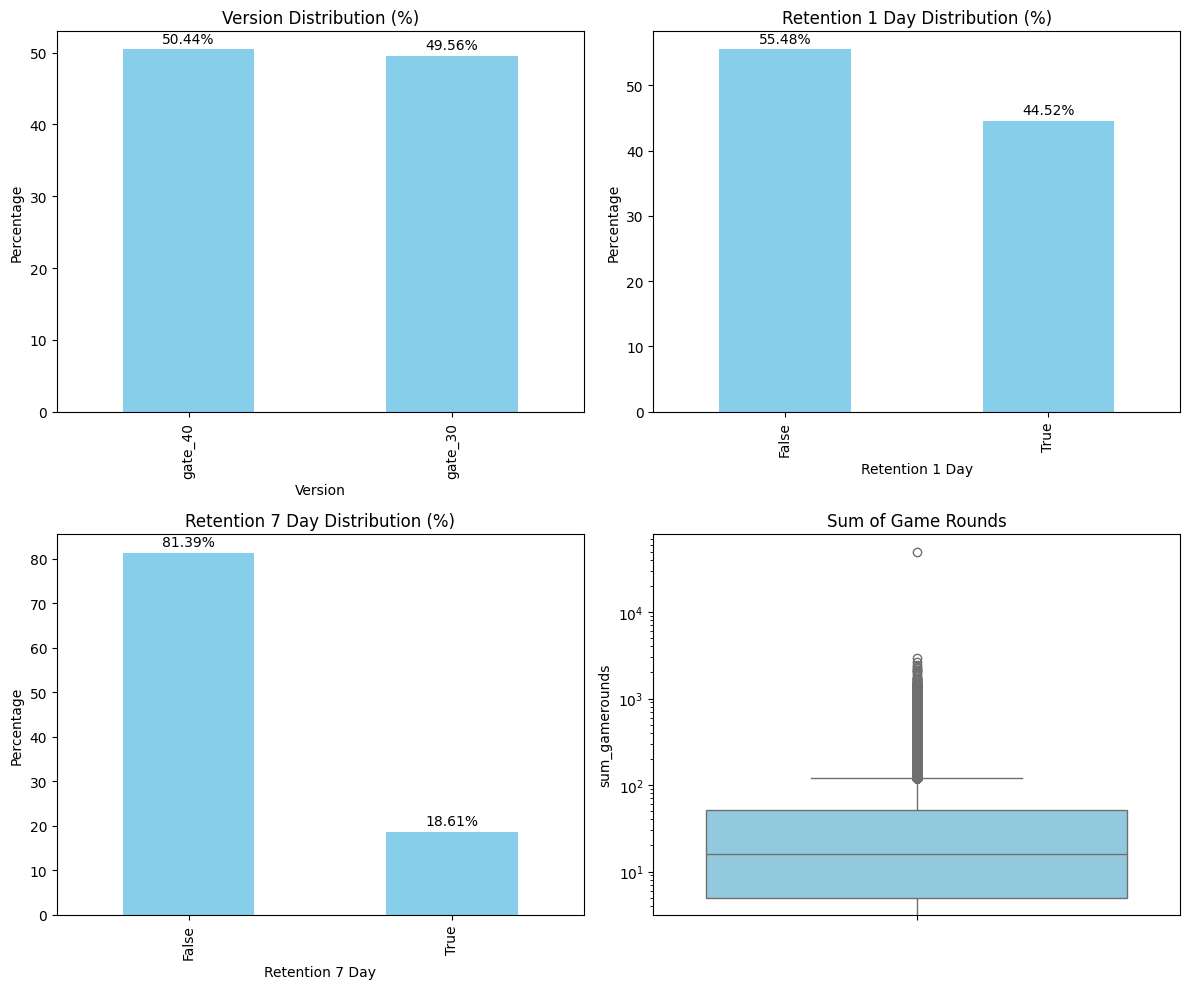

In [77]:
version_counts = df['version'].value_counts(normalize=True) * 100
retention_1_counts = df['retention_1'].value_counts(normalize=True) * 100
retention_7_counts = df['retention_7'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

def add_percentage_labels(ax, counts):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'baseline',
                    fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

version_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue')
add_percentage_labels(axes[0, 0], version_counts)
axes[0, 0].set_title('Version Distribution (%)')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].set_xlabel('Version')

retention_1_counts.plot(kind='bar', ax=axes[0, 1], color='skyblue')
add_percentage_labels(axes[0, 1], retention_1_counts)
axes[0, 1].set_title('Retention 1 Day Distribution (%)')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].set_xlabel('Retention 1 Day')

retention_7_counts.plot(kind='bar', ax=axes[1, 0], color='skyblue')
add_percentage_labels(axes[1, 0], retention_7_counts)
axes[1, 0].set_title('Retention 7 Day Distribution (%)')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xlabel('Retention 7 Day')

sns.boxplot(ax=axes[1, 1], y=df['sum_gamerounds'], color='skyblue')
axes[1, 1].set_title('Sum of Game Rounds')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

We notice that the percentage of users assigned to one or another version is not equal. Also feature sum_gamerounds has skewed distribution and multiple outliers.

In [78]:
# To count occurrences of each combination of retention_1 and retention_7
result = pd.crosstab(index=[df['retention_1']],
                     columns=df['retention_7'],
                     dropna=False,
                     rownames=['retention_1'],
                     colnames=['retention_7'],
                     margins=True,
                     margins_name='Total')

result

retention_7,False,True,Total
retention_1,,,
False,46437,3599,50036
True,26971,13182,40153
Total,73408,16781,90189


It is possible that users could not come back after one day but come back after seven days, also the majority of the users assigned to this experiment didn't come back neither after one nor seven days.


In [79]:
describe = df.groupby('version')['sum_gamerounds'].describe()

describe

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In [80]:
# Additional statistics
skewness = df['sum_gamerounds'].skew()
kurtosis = df['sum_gamerounds'].kurtosis()
print(f'Skewness: {skewness:.2f}')
print(f'Kurtosis: {kurtosis:.2f}')

Skewness: 185.44
Kurtosis: 47130.37


In both versions max values are quite huge, even hardly plausible if we take into account that this amount of games should be collected within 14 days, we will try to apply interquartile method to indicate outliers.

In [81]:
Q1 = df['sum_gamerounds'].quantile(0.25)
Q3 = df['sum_gamerounds'].quantile(0.75)
IQR = Q3 - Q1

# Define thresholds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers_df = df[
    (df['sum_gamerounds'] < lower_bound) | (df['sum_gamerounds'] > upper_bound)]

print("Outliers based on IQR summary:")
outliers_df['sum_gamerounds'].describe()

Outliers based on IQR summary:


,sum_gamerounds
count,10177.000000
mean,271.170581
std,526.338551
min,121.000000
25%,153.000000
50%,204.000000
75%,309.000000
max,49854.000000


As we see, if we remove the outliers by this method we will loose the 1/8 of the data, but in gaming context we could expect natural outliers - players who are very prolific, so further we will set a threshold of 1000 games per 14 days (70 plays per day quite plausible) and only remove those rows which exceed this threshold, assuming that physically to cross this numbers is quite difficult and that very huge numbers (such as 49854) could appear due to some bots' activity.

In [82]:
filtered_df = df[(df['sum_gamerounds'] > 1000)]

filtered_df

,userid,version,sum_gamerounds,retention_1,retention_7
655,69927,gate_30,1906,True,True
1097,121303,gate_30,1374,True,True
2257,248748,gate_30,1309,True,True
2586,284610,gate_30,1252,True,True
2692,294376,gate_40,1315,True,True
...,...,...,...,...,...
85964,9521620,gate_40,1252,True,True
86047,9530845,gate_40,1145,True,True
86904,9628337,gate_40,1082,True,True
87007,9640085,gate_30,2156,True,True


In [83]:
# Remove the filtered rows from the original df
df_cleaned = df[~df.index.isin(filtered_df.index)]

df_cleaned

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [84]:
samples = df_cleaned.groupby('version')['userid'].count()

samples

,userid
version,
gate_30,44647
gate_40,45426


In [85]:
# Calculate the expected counts (if there was no SRM)
total_users = samples.sum()
num_groups = len(samples)
expected_counts = [total_users / num_groups]

# Perform the chi-square test
chi2, p_value = chisquare(samples, f_exp=expected_counts)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Sample sizes are significantly different. Possible SRM detected.")
else:
    print("Sample sizes are not significantly different. No SRM detected.")

Chi-square statistic: 6.737213149334429
P-value: 0.009442201538799067
Sample sizes are significantly different. Possible SRM detected.


Since expected counts for each groups differs from 50/50 split, we could expect some sample ratio mismatch, so for further analysis we will randomly take out the number of users from bigger group to match the number of users from the smaller group.

In [86]:
larger_group = samples.idxmax()
smaller_group = samples.idxmin()

smaller_group_size = samples[smaller_group]

# Randomly sample users from the larger group to match the smaller group's size
larger_group_sample = df_cleaned[
    df_cleaned['version'] == larger_group].sample(n=smaller_group_size,
                                                  random_state=42)

smaller_group_users = df_cleaned[df_cleaned['version'] == smaller_group]

balanced_df = pd.concat([larger_group_sample, smaller_group_users])

df=balanced_df

print(df['version'].value_counts())

version
gate_40    44647
gate_30    44647
Name: count, dtype: int64


In [87]:
describe = df.groupby('version')['sum_gamerounds'].describe()

describe

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44647.0,49.825789,90.988489,0.0,5.0,17.0,50.0,997.0
gate_40,44647.0,49.433198,90.607207,0.0,5.0,16.0,52.0,1000.0


Now, we will analyze the distribution of the data and choose the metrics to be sensitive and also robust to evaluate the activity.

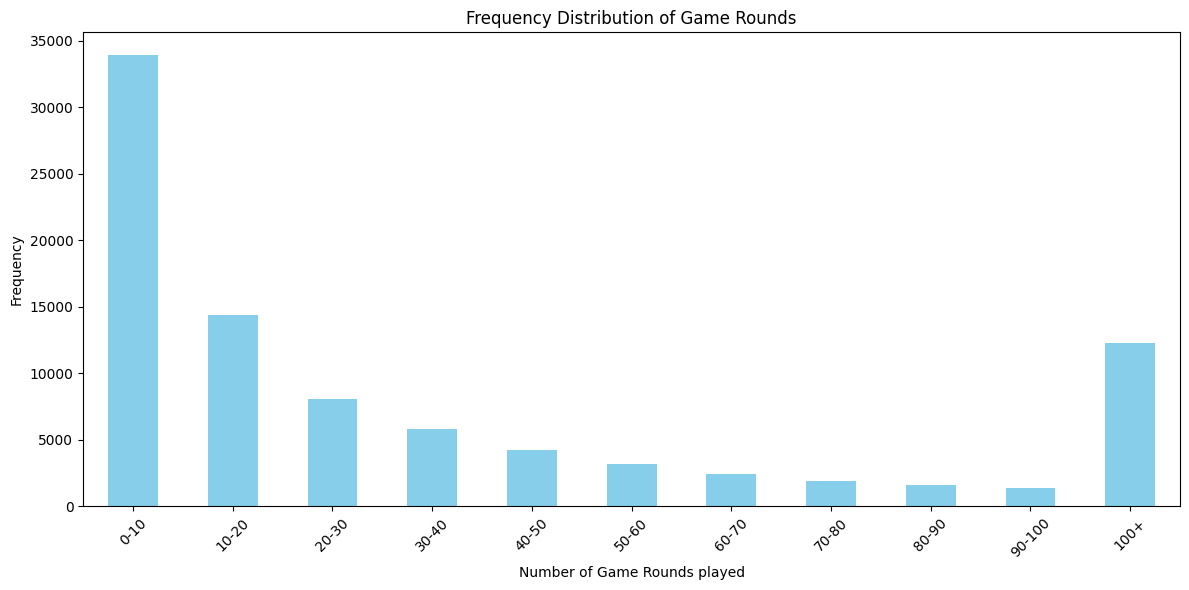

In [88]:
# Since we have multiple sums of games, let's put it to the bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50',
          '50-60', '60-70', '70-80', '80-90', '90-100', '100+']

df['binned_gamerounds'] = pd.cut(df['sum_gamerounds'],
                                 bins=bins, labels=labels, right=False)

frequency_table = df['binned_gamerounds'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
frequency_table.plot(kind='bar', color='skyblue')
plt.title('Frequency Distribution of Game Rounds')
plt.xlabel('Number of Game Rounds played')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

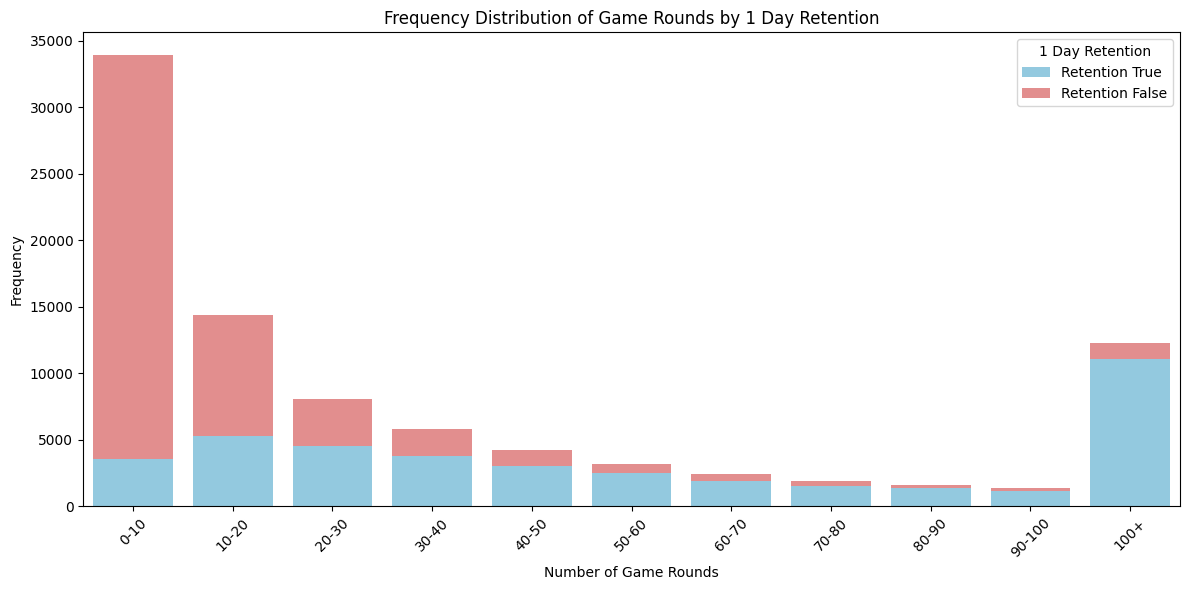

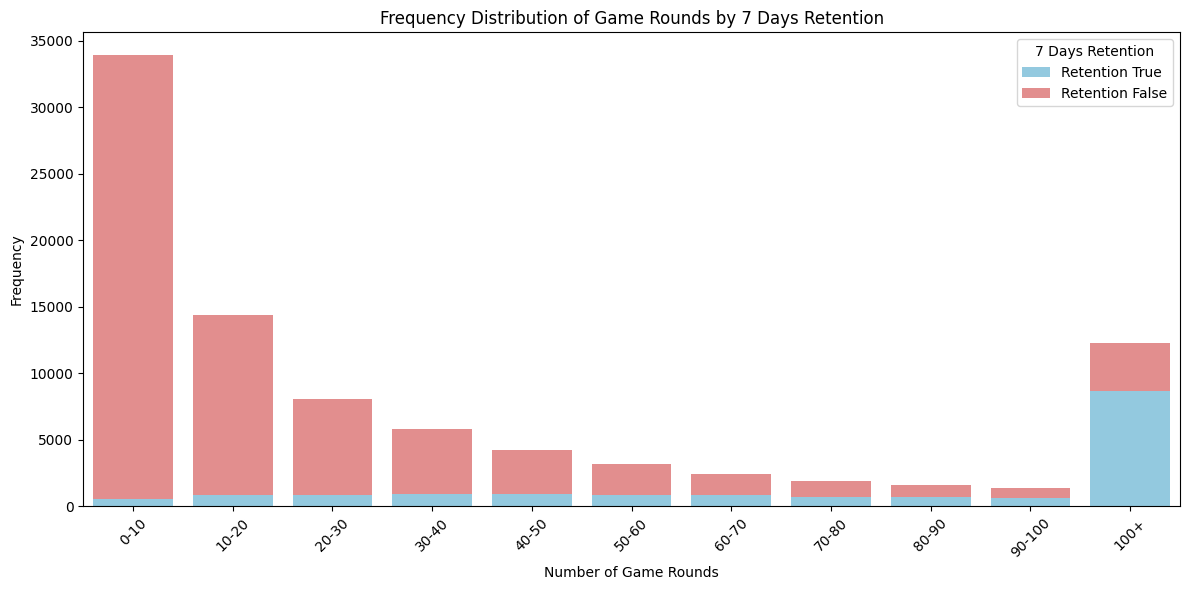

In [89]:
# Function plotting True/False retention frequency by bins
def plot_retention_distribution(df, retention_column, title):
    # Define the bins and labels
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60',
              '60-70', '70-80', '80-90', '90-100', '100+']

    # Compute counts for each bin and retention status
    counts = (df.groupby(['binned_gamerounds', retention_column],
                         observed=False)
              .size()
              .unstack(fill_value=0)
              .reindex(labels, fill_value=0))

    counts = counts.reset_index()

    plt.figure(figsize=(12, 6))

    sns.barplot(data=counts, x='binned_gamerounds', y=True,
                color='skyblue', label='Retention True')
    sns.barplot(data=counts, x='binned_gamerounds', y=False,
                color='lightcoral',
                label='Retention False', bottom=counts[True])

    plt.title(f'Frequency Distribution of Game Rounds by {title}')
    plt.xlabel('Number of Game Rounds')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend(title=title)

    plt.tight_layout()
    plt.show()

# Call plotting for 1-day retention
df['binned_gamerounds'] = pd.cut(df['sum_gamerounds'],
                                 bins=bins, labels=labels, right=False)
plot_retention_distribution(df, 'retention_1', '1 Day Retention')

# Call plotting for 7-days retention
plot_retention_distribution(df, 'retention_7', '7 Days Retention')

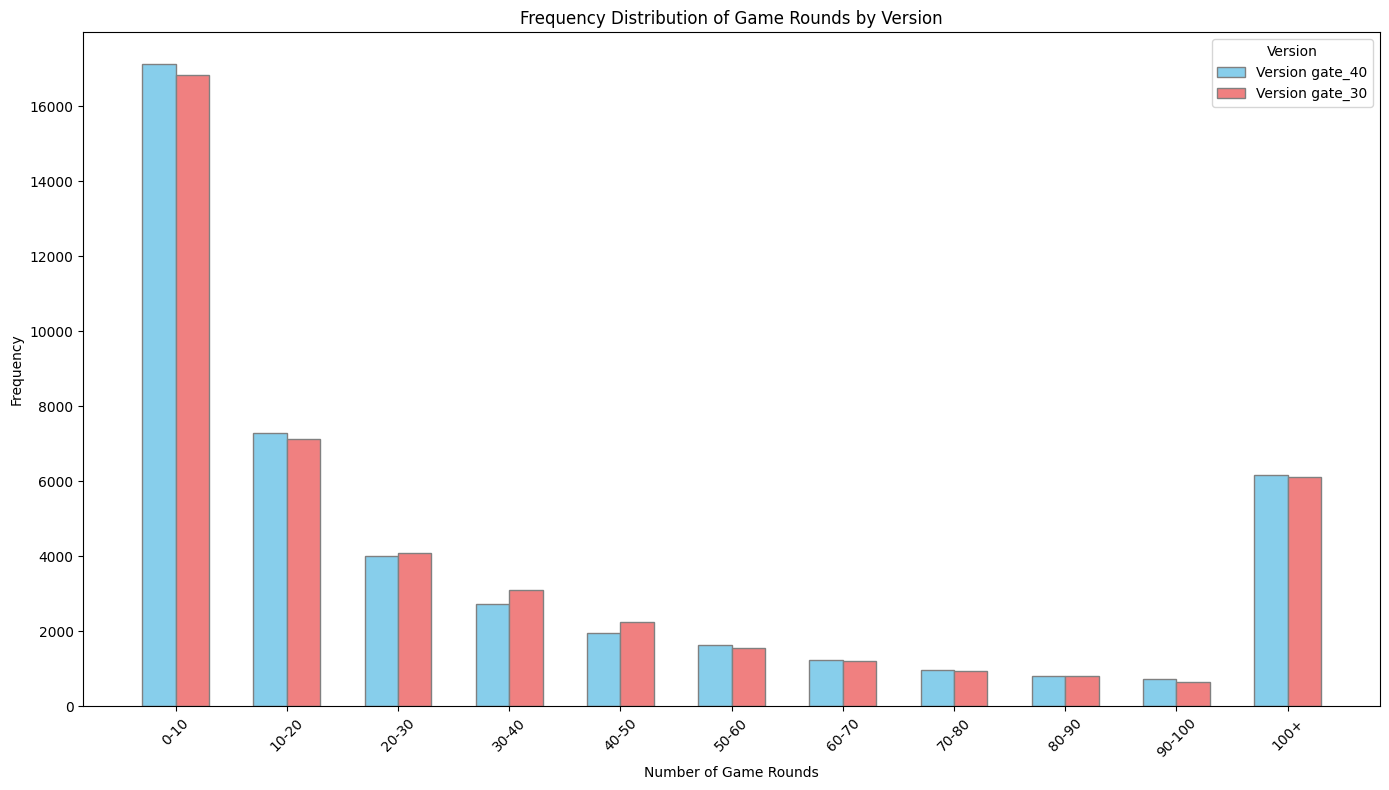

In [90]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50',
          '50-60', '60-70', '70-80', '80-90', '90-100', '100+']

plt.figure(figsize=(14, 8))

colors = ['skyblue', 'lightcoral']

# Plotting frequency distribution for each version
versions = df['version'].unique()
bar_width = 0.30

r = np.arange(len(labels))

for i, version in enumerate(versions):
    subset = df[df['version'] == version].copy()
    subset.loc[:, 'binned_gamerounds'] = pd.cut(subset['sum_gamerounds'],
                                                bins=bins,
                                                labels=labels,
                                                right=False)
    frequency_table = subset['binned_gamerounds'].value_counts().sort_index()

    plt.bar(r + i * bar_width, frequency_table, color=colors[i % len(colors)],
            width=bar_width, edgecolor='grey', label=f'Version {version}')


plt.title('Frequency Distribution of Game Rounds by Version')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Frequency')
plt.xticks(r + bar_width * (len(versions) - 1) / 2, labels, rotation=45)
plt.legend(title='Version')

plt.tight_layout()
plt.show()

Since distribution is skewed to the smaller values, meaning that majority or the values are concentrated to the less number of games played, and also average number of games could be very sensitive to outliers, will take a proportion of those who played certain number of games.

In [91]:
# 50 games - 75 percentile of control version
df['Less_than_50'] = df['sum_gamerounds'] < 50
df['50_and_more'] = df['sum_gamerounds'] >= 50


num_less_than_50 = df['Less_than_50'].sum()
num_50_and_more = df['50_and_more'].sum()

total_users = len(df)

percentage_less_than_50 = round((num_less_than_50 / total_users) * 100, 2)
percentage_50_and_more = round((num_50_and_more / total_users) * 100, 2)

data = {
    'Number of Users': [num_less_than_50, num_50_and_more],
    'Percentage': [percentage_less_than_50, percentage_50_and_more]
}

categories = ['Less than 50 games', '50 and more games']


result_df = pd.DataFrame(data, index=categories)

result_df

,Number of Users,Percentage
Less than 50 games,66471,74.44
50 and more games,22823,25.56


# Define the Experiment interest

For this A/B test, we aim to answer the following three questions:

</br>

Question 1: Has other version (gate_40) was better than the old version (gate_30) by more than 2% in terms of the proportion of those who played more than 50 games?

</br>

Null Hypothesis (H0): The proportion of users who played more than 50 games has not increased by more than 2% relative to the control group.

Alternative Hypothesis (H1): The proportion of users who played more than 50 games has increased by more than 2% relative to the control group.

</br>

Question 2: Has player retention increased by 3% after 1 day?

</br>

Null Hypothesis (H0): The player retention rate one day after installation in the treatment group has not increased by 3% compared to the control group.

Alternative Hypothesis (H1): The player retention rate one day after installation in the treatment group has increased by 3% compared to the control group.

</br>

Question 3: Has player retention increased by 2% after 7 days?

</br>

Null Hypothesis (H0): The player retention rate seven days after installation in the treatment group has not increased by 2% compared to the control group.

Alternative Hypothesis (H1): The player retention rate seven days after installation in the treatment group has increased by 2% compared to the control group.

## Question 1: Has version gate_40 was better relatively to the old version gate_30 by 2% in terms of the proportion of those who played more than 50 games?

For this question we assume that required sizes samples were collected. 2% is based on the assumtion that in general we cannot expect high percentages in online controlled experiments, and for this particular dataset we were lacking some context details or historical data, so let's state that more than 2% relatively better performance could also worth to consider from the business perspective.  

Proportions with Confidence Intervals for each version:
         Proportion (%)  CI Lower Bound (%)  CI Upper Bound (%)
version                                                        
gate_30       24.823616           24.425088           25.226476
gate_40       25.520192           25.117908           25.926688

Comparison between gate_30 and gate_40:
Z-Test Statistic: -2.3980535062059856
p-value: 0.016482457378097372
There is a significant difference in proportions



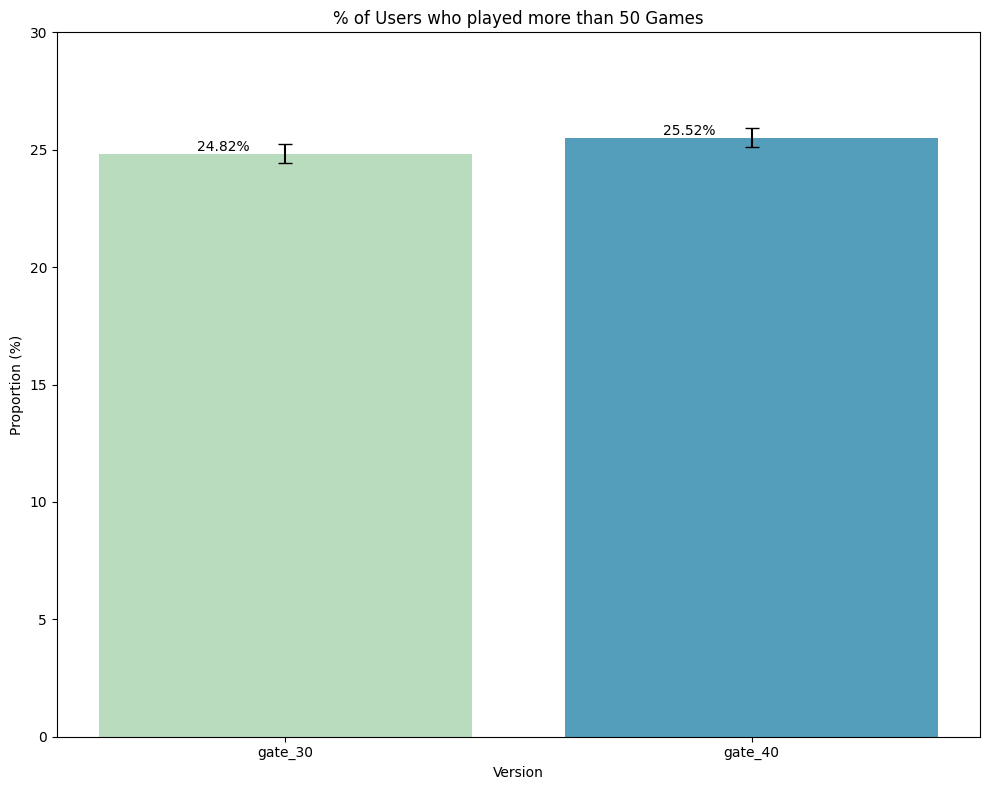

In [102]:
# Binarize the game rounds played
df['played_more_than_50'] = df['sum_gamerounds'] > 50

# Calculate counts and proportions for each version
version_counts = df.groupby('version')['played_more_than_50'].agg(['sum', 'count'])
version_counts['proportion'] = version_counts['sum'] / version_counts['count'] * 100

# Function to calculate and print proportions with confidence intervals
def calculate_proportions_and_confidence_intervals(version_counts):
    confidence_intervals = {}
    for version in version_counts.index:
        count = version_counts.loc[version, 'sum']
        nobs = version_counts.loc[version, 'count']
        ci_lower, ci_upper = proportion_confint(count, nobs, alpha=0.05, method='wilson')
        ci_lower_percent = ci_lower * 100
        ci_upper_percent = ci_upper * 100
        confidence_intervals[version] = (ci_lower_percent, ci_upper_percent)

    # Combine proportions and confidence intervals
    ci_df = pd.DataFrame(confidence_intervals, index=['CI Lower Bound (%)', 'CI Upper Bound (%)']).T
    result_df = version_counts[['proportion']].join(ci_df)
    result_df.rename(columns={'proportion': 'Proportion (%)'}, inplace=True)

    return result_df

result_df = calculate_proportions_and_confidence_intervals(version_counts)

print("Proportions with Confidence Intervals for each version:")
print(result_df)
print()


# Function to perform z-test for two proportions and interpret the results
def compare_proportions(version1, version2):
    count = [version_counts.loc[version1, 'sum'], version_counts.loc[version2, 'sum']]
    nobs = [version_counts.loc[version1, 'count'], version_counts.loc[version2, 'count']]

    z_stat, pval = proportions_ztest(count, nobs)

    print(f"Comparison between {version1} and {version2}:")
    print(f'Z-Test Statistic: {z_stat}')
    print(f'p-value: {pval}')

    alpha = 0.05
    if pval < alpha:
        print('There is a significant difference in proportions')
    else:
        print('There is no significant difference in proportions')
    print()


# Get the unique versions & compare
versions = version_counts.index.tolist()

for i in range(len(versions)):
    for j in range(i + 1, len(versions)):
        compare_proportions(versions[i], versions[j])


plt.figure(figsize=(10, 8))
ax=sns.barplot(x=result_df.index, y=result_df['Proportion (%)'],
               hue=result_df.index, palette='GnBu', errorbar=None)
plt.errorbar(x=np.arange(len(result_df.index)),
             y=result_df['Proportion (%)'],
             yerr=[result_df['Proportion (%)'] - result_df['CI Lower Bound (%)'],
                   result_df['CI Upper Bound (%)'] - result_df['Proportion (%)']],
             fmt='none', c='black', capsize=5)

#Add labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%',
                (p.get_x() + p.get_width() / 3., height),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10, color='black')

plt.title('% of Users who played more than 50 Games')
plt.xlabel('Version')
plt.ylabel('Proportion (%)')
plt.ylim(0, 30)

plt.tight_layout()
plt.show()

In [93]:
# Calculate lift
baseline_version = 'gate_30'
baseline_proportion = result_df.loc[baseline_version, 'Proportion (%)']

for version in result_df.index:
    if version != baseline_version:
        proportion = result_df.loc[version, 'Proportion (%)']
        lift = ((proportion - baseline_proportion) / baseline_proportion) * 100
        result_df.loc[version, 'Lift (%)'] = lift

result_df

,Proportion (%),CI Lower Bound (%),CI Upper Bound (%),Lift (%)
version,,,,
gate_30,24.823616,24.425088,25.226476,NaN
gate_40,25.520192,25.117908,25.926688,2.806099



The difference is the raw change in percentage points (absolute difference), whereas the lift expresses this change as a proportion of the control group's value, providing a relative measure of the improvement.

</br>

Based on the results we could assume that gate_40 version was better compare to gate_30 version in terms of proportion who played more than 50 times during 14 days. Identified lift was 2.8% (H0 rejected).

</br>


## Question 2 and 3: Has player retention increased by 3% after 1 day and by 2% after 7 days?

For questions 2 and 3 we will assume, that A/B testing need to calculate sample size for the expected effect size. First, we will set acceptable probabilities for Type I and Type II errors to ensure the robustness of our test results.

</br>

Type I Error (Alpha)
Definition: Type I error, denoted by  α, is the probability of rejecting the null hypothesis when it is actually true. In other words, it represents the risk of concluding that there is an effect or difference when, in reality, there is none.

Common Value: The commonly accepted value for α is 0.05 (5%). This means that there is a 5% risk of committing a Type I error.

</br>

Implication for our A/B tests:
</br>

Question 2: If we incorrectly conclude that player retention has increased by 3% after 1 day when it has not, we commit a Type I error.
</br>
Question 3: If we incorrectly conclude that player retention has increased by 2% after 7 days when it has not, we commit a Type I error.

</br>

Type II Error (Beta)
Definition: Type II error, denoted by  β, is the probability of failing to reject the null hypothesis when it is actually false. In other words, it represents the risk of concluding that there is no effect or difference when, in reality, there is one.

Common Value: The commonly accepted value for  β is 0.20 (20%). This means that there is a 20% risk of committing a Type II error.
</br>

Power of the Test: The power of a test is defined as  1-β.
</br>
A common power value is 0.80 (80%), indicating an 80% chance of correctly rejecting the null hypothesis when it is false.

</br>

Implication for our A/B tests:


Question 2: If we fail to detect an actual increase of 3% in player retention after 1 day, we commit a Type II error.
</br>
Question 3: If we fail to detect an actual increase of 2% in player retention after 7 days, we commit a Type II error.
</br>






In [94]:
# Define alpha, beta, and power
alpha = 0.05
beta = 0.20
power = 1 - beta # 80% power

These values balance between minimizing the risk of Type I and Type II errors, so that test results are both reliable and statistically significant. Based on expected effect size, we will calculate sample sizes.

In [95]:
control_group = df[df['version'] == 'gate_30']
treatment_group = df[df['version'] == 'gate_40']

# Baseline and expected proportions for retention rates
p1_retention_1 = control_group['retention_1'].mean()
p2_retention_1 = p1_retention_1 + 0.03  # 3% increase for retention after 1 day

p1_retention_7 = control_group['retention_7'].mean()
p2_retention_7 = p1_retention_7 + 0.02  # 2% increase for retention after 7 days

# Calculate sample sizes
effect_size_retention_1 = sms.proportion_effectsize(p1_retention_1, p2_retention_1)
n_retention_1 = sms.NormalIndPower().solve_power(
    effect_size=effect_size_retention_1, power=power, alpha=alpha, ratio=1)

effect_size_retention_7 = sms.proportion_effectsize(p1_retention_7, p2_retention_7)
n_retention_7 = sms.NormalIndPower().solve_power(
    effect_size=effect_size_retention_7, power=power, alpha=alpha, ratio=1)

print(f"Required sample size for retention after 1 day test: {int(n_retention_1)}")
print(f"Required sample size for retention after 7 days test: {int(n_retention_7)}")

Required sample size for retention after 1 day test: 4334
Required sample size for retention after 7 days test: 6257


Proportion of True values for gate_30: 45.15%
95% Confidence Interval for gate_30: (43.68%, 46.64%)
Proportion of True values for gate_40: 43.89%
95% Confidence Interval for gate_40: (42.41%, 45.37%)



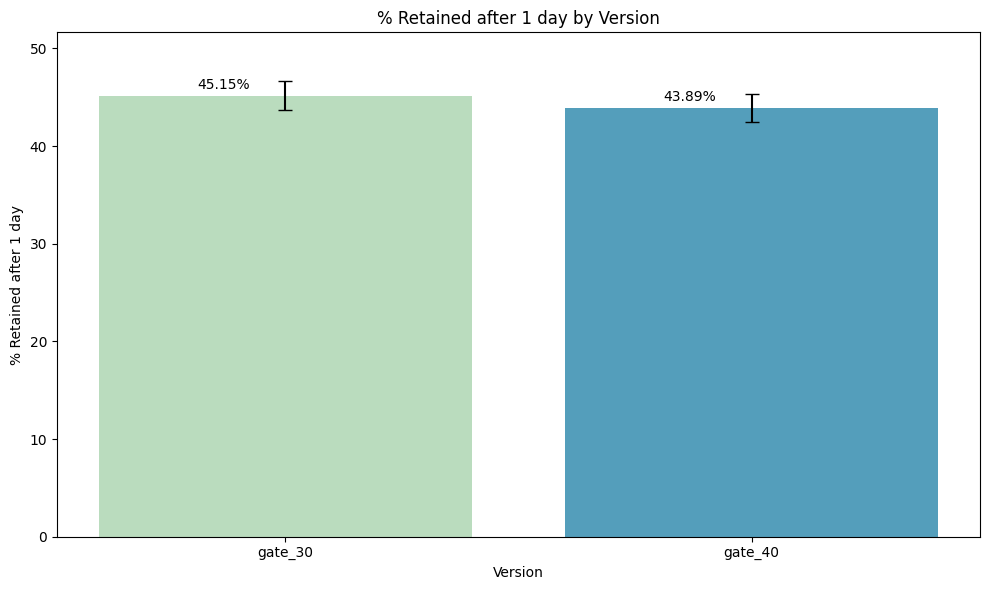

In [96]:
# Define the sample size for each version
sample_size_per_version = 4334

# Sample randomly
gate_30_data = df[df['version'] == 'gate_30'].sample(n=sample_size_per_version, random_state=1)
gate_40_data = df[df['version'] == 'gate_40'].sample(n=sample_size_per_version, random_state=1)

combined_sample = pd.concat([gate_30_data, gate_40_data])

# Calculate the number of True values and total observations for each version
gate_30_successes = gate_30_data['retention_1'].sum()
gate_40_successes = gate_40_data['retention_1'].sum()

gate_30_total = len(gate_30_data)
gate_40_total = len(gate_40_data)

# Calculate the proportions for each version as percentages
proportion_gate_30 = (gate_30_successes / gate_30_total) * 100
proportion_gate_40 = (gate_40_successes / gate_40_total) * 100

# Calculate 95% confidence intervals for each proportion
ci_gate_30 = sms.proportion_confint(gate_30_successes, gate_30_total, method='wilson')
ci_gate_40 = sms.proportion_confint(gate_40_successes, gate_40_total, method='wilson')

# Convert CIs to percentages
ci_gate_30 = (ci_gate_30[0] * 100, ci_gate_30[1] * 100)
ci_gate_40 = (ci_gate_40[0] * 100, ci_gate_40[1] * 100)

print(f"Proportion of True values for gate_30: {proportion_gate_30:.2f}%")
print(f"95% Confidence Interval for gate_30: ({ci_gate_30[0]:.2f}%, {ci_gate_30[1]:.2f}%)")
print(f"Proportion of True values for gate_40: {proportion_gate_40:.2f}%")
print(f"95% Confidence Interval for gate_40: ({ci_gate_40[0]:.2f}%, {ci_gate_40[1]:.2f}%)")
print()

data = {
    'version': ['gate_30', 'gate_40'],
    'proportion': [proportion_gate_30, proportion_gate_40],
    'ci_lower': [ci_gate_30[0], ci_gate_40[0]],
    'ci_upper': [ci_gate_30[1], ci_gate_40[1]]
}

plot_data = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='version', y='proportion',
                   data=plot_data, hue='version',
                   palette='GnBu', errorbar=None)

# Add error bars
for i in range(len(plot_data)):
    plt.errorbar(x=i,
                 y=plot_data['proportion'][i],
                 yerr=[[plot_data['proportion'][i] - plot_data['ci_lower'][i]],
                       [plot_data['ci_upper'][i] - plot_data['proportion'][i]]],
                 fmt='none',
                 color='black',
                 capsize=5)

plt.title('% Retained after 1 day by Version')
plt.xlabel('Version')
plt.ylabel('% Retained after 1 day')
plt.ylim(0, max(plot_data['ci_upper']) + 5)

# Adding labels on the bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}%',
                  (bar.get_x() + bar.get_width() / 3, height),
                  ha='center',
                  va='bottom',
                  xytext=(0, 3),
                  textcoords='offset points')

plt.tight_layout()
plt.show()

Bootstrapped 95% Confidence Interval for gate_30: (43.63%, 46.70%)
Bootstrapped 95% Confidence Interval for gate_40: (42.39%, 45.34%)



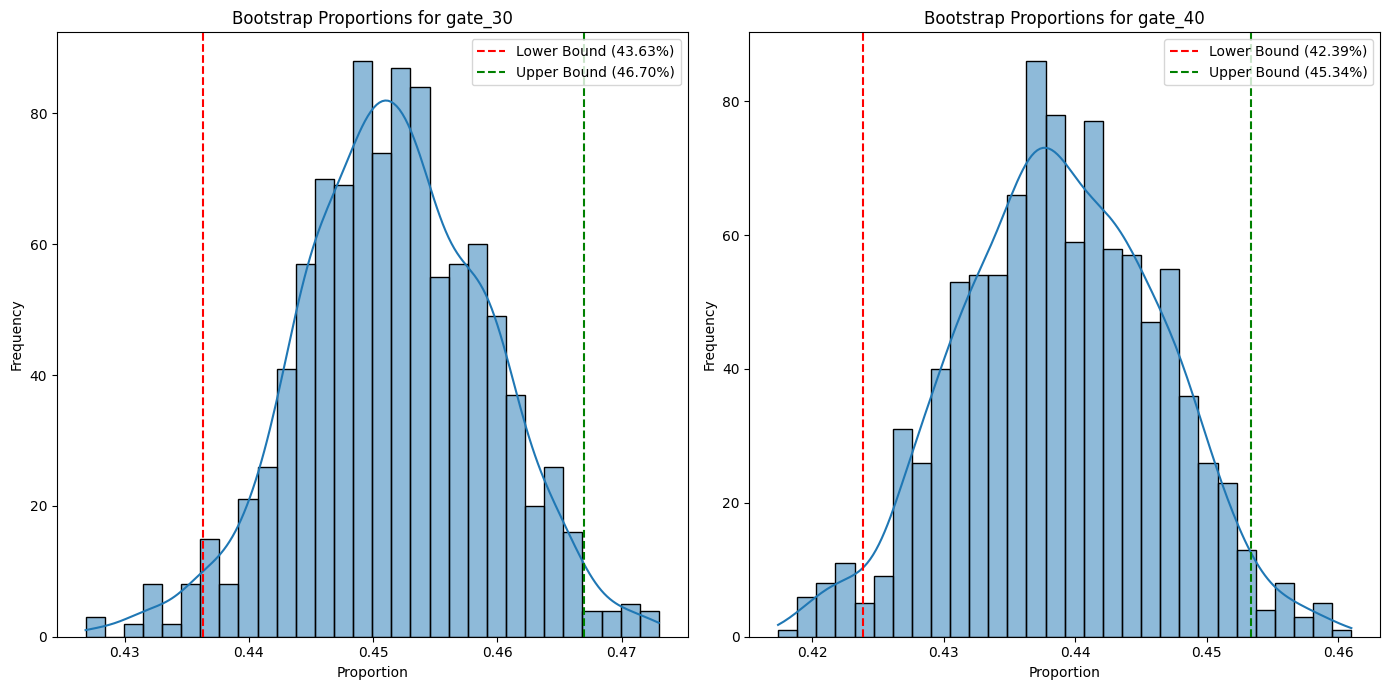

In [97]:
def bootstrap_proportion_ci(data, num_iterations=1000, alpha=0.05):
    bootstrap_proportions = []

    # Number of observations in the data
    n = len(data)

    for _ in range(num_iterations):
        # Resample with replacement
        sample = np.random.choice(data, size=n, replace=True)

        # Calculate proportion of successes in the bootstrap sample
        proportion = np.mean(sample)

        bootstrap_proportions.append(proportion)

    bootstrap_proportions = np.array(bootstrap_proportions)

    # Calculate the lower and upper percentiles for the confidence interval
    lower_bound = np.percentile(bootstrap_proportions, 100 * alpha / 2)
    upper_bound = np.percentile(bootstrap_proportions, 100 * (1 - alpha / 2))

    return lower_bound, upper_bound, bootstrap_proportions

# Data preparation
gate_30_data = combined_sample[combined_sample['version'] == 'gate_30']['retention_1']
gate_40_data = combined_sample[combined_sample['version'] == 'gate_40']['retention_1']

# Calculate proportions
gate_30_proportion = gate_30_data.mean()
gate_40_proportion = gate_40_data.mean()

# Bootstrap confidence intervals
ci_gate_30_bootstrap = bootstrap_proportion_ci(gate_30_data)[:2]
bootstrap_proportions_30 = bootstrap_proportion_ci(gate_30_data)[2]

ci_gate_40_bootstrap = bootstrap_proportion_ci(gate_40_data)[:2]
bootstrap_proportions_40 = bootstrap_proportion_ci(gate_40_data)[2]

print(f"Bootstrapped 95% Confidence Interval for gate_30: "
      f"({ci_gate_30_bootstrap[0]*100:.2f}%, {ci_gate_30_bootstrap[1]*100:.2f}%)")

print(f"Bootstrapped 95% Confidence Interval for gate_40: "
      f"({ci_gate_40_bootstrap[0]*100:.2f}%, {ci_gate_40_bootstrap[1]*100:.2f}%)")
print()


plt.figure(figsize=(14, 7))

# Histogram for gate_30
plt.subplot(1, 2, 1)
sns.histplot(bootstrap_proportions_30, bins=30, kde=True)
plt.axvline(ci_gate_30_bootstrap[0], color='red', linestyle='--',
            label=f'Lower Bound ({ci_gate_30_bootstrap[0]*100:.2f}%)')
plt.axvline(ci_gate_30_bootstrap[1], color='green', linestyle='--',
            label=f'Upper Bound ({ci_gate_30_bootstrap[1]*100:.2f}%)')
plt.title('Bootstrap Proportions for gate_30')
plt.xlabel('Proportion')
plt.ylabel('Frequency')
plt.legend()

# Histogram for gate_40
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_proportions_40, bins=30, kde=True)
plt.axvline(ci_gate_40_bootstrap[0], color='red', linestyle='--',
            label=f'Lower Bound ({ci_gate_40_bootstrap[0]*100:.2f}%)')
plt.axvline(ci_gate_40_bootstrap[1], color='green', linestyle='--',
            label=f'Upper Bound ({ci_gate_40_bootstrap[1]*100:.2f}%)')
plt.title('Bootstrap Proportions for gate_40')
plt.xlabel('Proportion')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [98]:
successes = [gate_30_successes, gate_40_successes]
total_counts = [len(gate_30_data), len(gate_40_data)]

# Perform the proportion z-test
z_stat, p_val = sms.proportions_ztest(successes, total_counts)

print(f"Z-Test Statistic: {z_stat:.2f}")
print(f"P-Value: {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("There is a statistically significant difference between the proportions.")
else:
    print("There is no statistically significant difference between the proportions.")


Z-Test Statistic: 1.19
P-Value: 0.2346
There is no statistically significant difference between the proportions.


No differences in terms of retained customers after one day identified between game versions.

Proportion of True values for gate_30: 18.79%
95% Confidence Interval for gate_30: (17.85%, 19.78%)
Proportion of True values for gate_40: 18.03%
95% Confidence Interval for gate_40: (17.10%, 19.00%)



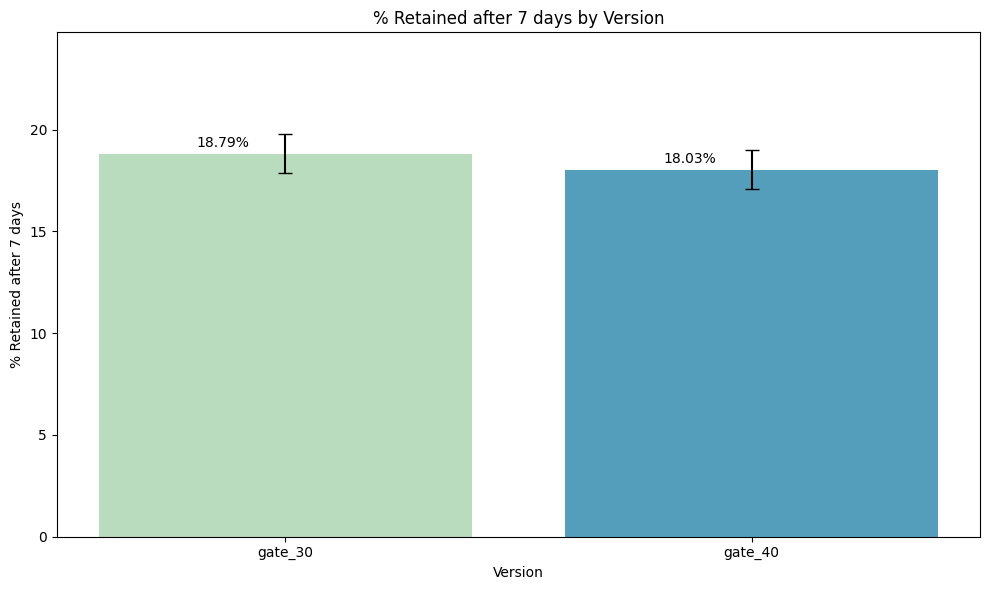

In [99]:
sample_size_per_version = 6257

# Sample randomly
gate_30_data = df[df['version'] == 'gate_30'].sample(
    n=sample_size_per_version, random_state=1)

gate_40_data = df[df['version'] == 'gate_40'].sample(
    n=sample_size_per_version, random_state=1)

combined_sample = pd.concat([gate_30_data, gate_40_data])


gate_30_successes = gate_30_data['retention_7'].sum()
gate_40_successes = gate_40_data['retention_7'].sum()

gate_30_total = len(gate_30_data)
gate_40_total = len(gate_40_data)


proportion_gate_30 = (gate_30_successes / gate_30_total)*100
proportion_gate_40 = (gate_40_successes / gate_40_total)*100

# Calculate 95% confidence intervals for each proportion
ci_gate_30 = sms.proportion_confint(gate_30_successes, gate_30_total, method='wilson')
ci_gate_40 = sms.proportion_confint(gate_40_successes, gate_40_total, method='wilson')


ci_gate_30 = (ci_gate_30[0] * 100, ci_gate_30[1] * 100)
ci_gate_40 = (ci_gate_40[0] * 100, ci_gate_40[1] * 100)

print(f"Proportion of True values for gate_30: {proportion_gate_30:.2f}%")
print(f"95% Confidence Interval for gate_30: ({ci_gate_30[0]:.2f}%, {ci_gate_30[1]:.2f}%)")
print(f"Proportion of True values for gate_40: {proportion_gate_40:.2f}%")
print(f"95% Confidence Interval for gate_40: ({ci_gate_40[0]:.2f}%, {ci_gate_40[1]:.2f}%)")
print()


data = {
    'version': ['gate_30', 'gate_40'],
    'proportion': [proportion_gate_30, proportion_gate_40],
    'ci_lower': [ci_gate_30[0], ci_gate_40[0]],
    'ci_upper': [ci_gate_30[1], ci_gate_40[1]]
}

plot_data = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='version', y='proportion',
                   data=plot_data, hue='version',
                   palette='GnBu', errorbar=None)

# Add error bars
for i in range(len(plot_data)):
    plt.errorbar(x=i,
                 y=plot_data['proportion'][i],
                 yerr=[[plot_data['proportion'][i] - plot_data['ci_lower'][i]],
                       [plot_data['ci_upper'][i] - plot_data['proportion'][i]]],
                 fmt='none',
                 color='black',
                 capsize=5)

plt.title('% Retained after 7 days by Version')
plt.xlabel('Version')
plt.ylabel('% Retained after 7 days')
plt.ylim(0, max(plot_data['ci_upper']) + 5)

# Adding labels on the bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}%',
                  (bar.get_x() + bar.get_width() / 3, height),
                  ha='center',
                  va='bottom',
                  xytext=(0, 3),
                  textcoords='offset points')

plt.tight_layout()
plt.show()

Bootstrapped 95% Confidence Interval for gate_30: (18.56%, 19.29%)
Bootstrapped 95% Confidence Interval for gate_40: (17.70%, 18.41%)



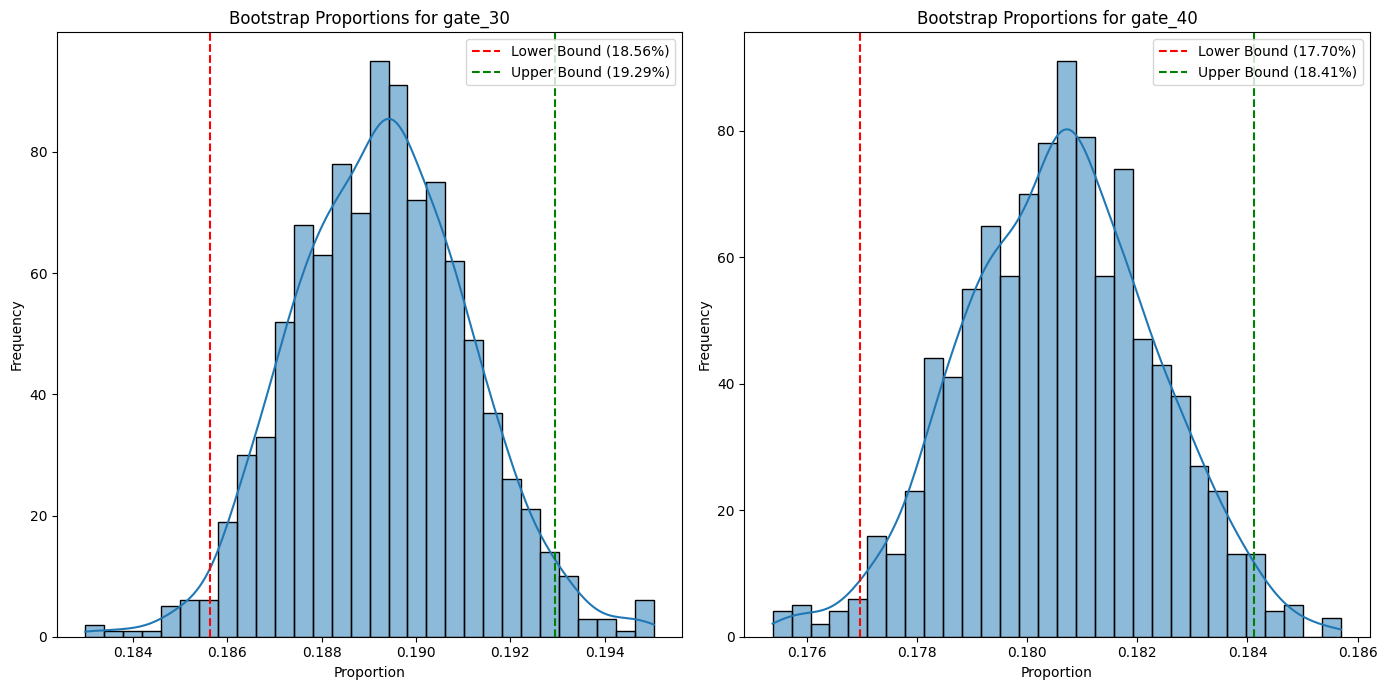

In [100]:
gate_30_data = df[df['version'] == 'gate_30']['retention_7']
gate_40_data = df[df['version'] == 'gate_40']['retention_7']

# Calculate proportions
gate_30_proportion = gate_30_data.mean()
gate_40_proportion = gate_40_data.mean()

# Bootstrap confidence intervals
ci_gate_30_bootstrap = bootstrap_proportion_ci(gate_30_data)[:2]
bootstrap_proportions_30 = bootstrap_proportion_ci(gate_30_data)[2]

ci_gate_40_bootstrap = bootstrap_proportion_ci(gate_40_data)[:2]
bootstrap_proportions_40 = bootstrap_proportion_ci(gate_40_data)[2]

print(f"Bootstrapped 95% Confidence Interval for gate_30: "
      f"({ci_gate_30_bootstrap[0]*100:.2f}%, {ci_gate_30_bootstrap[1]*100:.2f}%)")

print(f"Bootstrapped 95% Confidence Interval for gate_40: "
      f"({ci_gate_40_bootstrap[0]*100:.2f}%, {ci_gate_40_bootstrap[1]*100:.2f}%)")
print()

plt.figure(figsize=(14, 7))



# Histogram for gate_30
plt.subplot(1, 2, 1)
sns.histplot(bootstrap_proportions_30, bins=30, kde=True)
plt.axvline(ci_gate_30_bootstrap[0], color='red', linestyle='--',
            label=f'Lower Bound ({ci_gate_30_bootstrap[0]*100:.2f}%)')
plt.axvline(ci_gate_30_bootstrap[1], color='green', linestyle='--',
            label=f'Upper Bound ({ci_gate_30_bootstrap[1]*100:.2f}%)')
plt.title('Bootstrap Proportions for gate_30')
plt.xlabel('Proportion')
plt.ylabel('Frequency')
plt.legend()

# Histogram for gate_40
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_proportions_40, bins=30, kde=True)
plt.axvline(ci_gate_40_bootstrap[0], color='red', linestyle='--',
            label=f'Lower Bound ({ci_gate_40_bootstrap[0]*100:.2f}%)')
plt.axvline(ci_gate_40_bootstrap[1], color='green', linestyle='--',
            label=f'Upper Bound ({ci_gate_40_bootstrap[1]*100:.2f}%)')
plt.title('Bootstrap Proportions for gate_40')
plt.xlabel('Proportion')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
successes = [gate_30_successes, gate_40_successes]
total_counts = [len(gate_30_data), len(gate_40_data)]

# Perform the proportion z-test
z_stat, p_val = sms.proportions_ztest(successes, total_counts)

print(f"Z-Test Statistic: {z_stat:.2f}")
print(f"P-Value: {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("There is a statistically significant difference between the proportions.")
else:
    print("There is no statistically significant difference between the proportions.")

Z-Test Statistic: 1.01
P-Value: 0.3110
There is no statistically significant difference between the proportions.


Based on comparison results, no statistically significant differences were detected neither for retention after one day nor for retention after seven days, so we failed to reject H0 in both cases.
